<a href="https://colab.research.google.com/github/mayakerem/RecommendationSystem/blob/main/RS_Final_Project_Maya.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recommendation System Final Project

Maya Kerem (204818181)

Due Date: 21 / 02 / 2021

The goal of this project is to let you practice in a data scientist daily work by leveraging recommender
systems algorithms you learnt in the course and customize them in order to solve real business
problems.

We will use a dataset based on the [MovieLens 1M rating](https://grouplens.org/datasets/movielens/1m/) dataset after some pre-processing to adapt it
to an implicit feedback use case scenario. You can download the dataset used by [this implementation](https://github.com/hexiangnan/neural_collaborative_filtering) of the paper Neural Collaborative Filtering or from the NeuralCollaborativeFiltering_implicit notebook in
Moodle. 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import heapq
import math

import seaborn as sns
from time import time
import scipy.sparse as sp
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
import tensorflow as T
from tensorflow import keras
from keras import backend as K
from keras import initializers

from keras.initializers import RandomNormal
from keras.models import Sequential, Model, load_model, save_model
from keras.layers.core import Dense, Lambda, Activation
from keras.layers import Embedding, Input, Dense, Reshape,  Flatten, Dropout
from keras.optimizers import Adagrad, Adam, SGD, RMSprop, Adamax
from keras.regularizers import l2
from keras.layers import Multiply, Concatenate
sns.set_theme(font_scale=1.5)

import warnings
warnings.filterwarnings("ignore")

# Training parameters
num_factors = 8 # Size of embedding size.
num_negatives = 4 # Number of negative samples
learning_rate = 0.001
epochs = 12
batch_size = 512
verbose = 1
write_model=True
topK = 5 # Used to evaluate the model
evaluation_threads = 1

In [3]:
! git clone https://github.com/hexiangnan/neural_collaborative_filtering.git 


Cloning into 'neural_collaborative_filtering'...
remote: Enumerating objects: 66, done.
remote: Total 66 (delta 0), reused 0 (delta 0), pack-reused 66
Unpacking objects: 100% (66/66), done.


In [4]:
! ls neural_collaborative_filtering/Data/

ml-1m.test.negative  ml-1m.train.rating		 pinterest-20.test.rating
ml-1m.test.rating    pinterest-20.test.negative  pinterest-20.train.rating


In [5]:
def load_rating_file_as_list(filename):
  ratingList = []
  with open(filename, "r") as f:
    line = f.readline()
    while line != None and line != "":
      arr = line.split("\t")
      user, item = int(arr[0]), int(arr[1])
      ratingList.append([user, item])
      line = f.readline()
  return ratingList

def load_negative_file(filename):
  negativeList = []
  with open(filename, "r") as f:
    line = f.readline()
    while line != None and line != "":
      arr = line.split("\t")
      negatives = []
      for x in arr[1: ]:
        negatives.append(int(x))
      negativeList.append(negatives)
      line = f.readline()
  return negativeList
    
def load_rating_file_as_matrix(filename):
  # Get number of users and items
  num_users, num_items = 0, 0
  with open(filename, "r") as f:
    line = f.readline()
    while line != None and line != "":
      arr = line.split("\t")
      u, i = int(arr[0]), int(arr[1])
      num_users = max(num_users, u)
      num_items = max(num_items, i)
      line = f.readline()
  # Construct matrix
  mat = sp.dok_matrix((num_users+1, num_items+1), dtype=np.float32)
  with open(filename, "r") as f:
    line = f.readline()
    while line != None and line != "":
      arr = line.split("\t")
      user, item, rating = int(arr[0]), int(arr[1]), float(arr[2])
      if (rating > 0):
        mat[user, item] = 1.0
      line = f.readline()    
  return mat

t1 = time()

trainMatrix = load_rating_file_as_matrix('neural_collaborative_filtering/Data/ml-1m.train.rating')
testRatings = load_rating_file_as_list('neural_collaborative_filtering/Data/ml-1m.test.rating')
testNegatives = load_negative_file('neural_collaborative_filtering/Data/ml-1m.test.negative')

num_users, num_items = trainMatrix.shape
print("Load data done [%.1f s]. #user=%d, #item=%d, #train=%d, #test=%d" %(time()-t1, num_users, num_items, trainMatrix.nnz, len(testRatings)))

Load data done [13.2 s]. #user=6040, #item=3706, #train=994169, #test=6040


## Question 1: Matrix Factorization with custom loss (35 points)

You work for an e-commerce company “Buy Here”. You are using the Matrix Factorization algorithm to
recommend consumers with products which may be relevant to them using implicit feedback. The
product manager tells you that he wants to improve the accuracy of the prediction model for more
expensive products since these products are more profitable to the company.

One of the common techniques to be more accurate for more expensive products is to give a higher
weight in the loss function to more expensive products. You are using the Binary Cross Entropy loss
function which is suitable for binary classification problems. Here is the custom loss function, when
adding a weight to each instance in the training data, to give different weight for each sample

$L = −\frac{1}{N}\sum_{(i, j) \in S}^{N} \alpha_j (y_{i,j} log(\sigma (\mu + p_i + o_j + u_{i}^{T} v_j) + (i-y_{u,j}) log(1-\sigma(\mu + p_i + o_j + u^T_{i}v_j)))$

Here, $𝛼_𝑗$ is the weight for instances which involve item $j$, 

$𝜎(𝑧) = \frac{1}{1+e^{-z}}$ 

is the logistic function, $\mu$ is the global bias, $p_i, o_j$ are the user and item bias respectively and $u_i,v_j$ are column vectors with size $K$, representing the latent weight vector of the user $i$ and item $j$ respectively.

a. Derive the Gradient Decent update rule for the user and item latent vector weights as well as for
the global bias, user bias and item bias variables. Explain each step. (30 points)

***Answer***: 

Before we start deriving, lets define and recall the following:

a. $\log(\frac{x}{y}) = \log(x) - \log(y)$ 

b. $\sigma(z) = \frac{1}{1+e^{-z}}$

and

c. $z = \mu + p_{i} + o_{j} + {u}_{i}^{T}v_{j}$


Now we can start by deriving the provided loss function in the following way:

We can apply (a) and get that
$$ \log(\sigma (z)) = \log (\frac{1}{1+e^{-z}}) = \log(1) - \log(1+e^{-z}) = -\log(1+e^{-z}) $$

Similarly, we apply (a) here as well and get that
$$ \log (1 - \sigma (z)) = \log (1 - \frac{1}{1+e^{-z}}) = \log (\frac{1 + e^{-z} - 1}{1 + e^{-z}}) = \log (\frac {e^{-z}}{1+e^{-z}}) = \log(e^{-z}) - \log(1+e^{-z}) = - z - \log(1 + e^{-z}) = -(( z + \log(1 + e^{-z})))
$$

We apply this to the custom loss function above, $L$, using substitution $z$, achieving
$$
L = - \frac{1}{N} \sum_{(i, j) \in S}^{N} \alpha_{j}(y_{i, j} \log(\sigma(z))+(1 - y_{i, j}) \log(1 - \sigma(z)))
$$ 
Applying the calculations above we get
$$ 
= - \frac{1}{N} \sum_{(i, j) \in S}^{N} \alpha_{j}(- y_{i, j} \log(1 + e^{-z}) +(1 - y_{i, j}) (- (z + \log(1 + e^{-z}))))
$$
Distributing the negatives
$$
= \frac{1}{N} \sum_{(i, j) \in S}^{N} \alpha_{j}(y_{i, j} \log(1 + e^{-z}) + (1 - y_{i, j})(z + \log(1 + e^{-z}))) 
$$
Applying multiplication
$$
= \frac{1}{N} \sum_{(i, j) \in S}^{N} \alpha_{j}( z - y_{i, j} z + \log(1 + e^{-z}))
$$

Next we compute the partial derivaties for the forllowing vectors;
_Where users and items are represented by $i$, $j$, respectively_

- ($u_i,  v_j$) is the user and item latent vector weights

- ($\mu$) the global bias 

- ($p_i$) user bias 

- ($o_j$) is the and item bias 

By the chain rule, consider the following

d. 
$$ 
\frac{\partial (\alpha_{j} z)}{\partial {u_i}} = \frac{\partial (\alpha_{j} (\mu + p_{i} + o_{j} + {u}_{i}^{T} v_{j}))}{\partial {u_i}} = \alpha_{j} v_{j}
$$
e. 
$$
\frac{\partial (-\alpha_{j}  y_{i, j} z)}{\partial {u_i}} = \frac{\partial (- \alpha_{j} y_{i, j}(\mu+p_{i}+o_{j}+{u}_{i}^{T} v_{j}))} {\partial {u_i}} = - \alpha_{j} y_{i, j} v_{j}
$$
f. 
$$
\frac{\partial (\alpha_{j}  \log(1 + e^{- z}))}{\partial {u_i}} = \frac{\partial (\alpha_{j} \log(1 + e^{\mu + p_{i} + o_{j} + {u}_{i}^{T} v_{j}}))} {\partial {u_i}} = \frac{\alpha_j e^{-z} \frac{\partial {z}}{\partial {u_i}}} {1 + e^{- z}} = - \frac{\alpha_{j} e^{-z} v_{j}}{1 + e^{-z}}
$$

Then we apply (d) (e) (f) and  we calculate the partial derivative of the **user latent vector**
$$
\frac{\partial {L}}{\partial {u_i}} = \frac{1}{N} \sum_{(i, j) \in S}^{N} (( \alpha_{j} v_{j} - \alpha_{j} y_{i, j} v_{j} - \frac{\alpha_{j} e^{-z} v_{j}}{1 + e^{-z}})) 
= \frac{1}{N} \sum_{(i, j) \in S}^{N} \alpha_{j} v_{j} (( 1 - y_{i, j} - \frac{e^{-z}}{1 + e^{-z}})) 
$$

Similarity as above, we calculate the partial derivative of the **item latent vector**

$$
\frac{\partial {L}}{\partial {v_j}} = \frac{1}{N} \sum_{(i, j) \in S}^{N} ((\alpha_{j} {u}_{i}^{T} - \alpha_{j} y_{i, j} {u}_{i}^{T} - \frac{\alpha_{j} e^{-z} {u}_{i}^{T}}{1 + e^{-z}} )) 
= \frac{1}{N} \sum_{(i, j) \in S}^{N} \alpha_{j} {u}_{i}^{T} (( 1 - y_{i, j} - \frac{e^{-z}}{1 + e^{-z}} )) 
$$

For bias calculations consider the following

g. 
$$
\frac{\partial (\alpha_{j} z)}{\partial {\mu}} = \frac{\partial (\alpha_{j} (\mu+ p_{i} + o_{j} + {u}_{i}^{T} v_{j}))}{\partial {\mu}} = \alpha_{j}
$$

h. 
$$
\frac{\partial (-\alpha_{j}  y_{i, j} z)}{\partial \mu} = \frac{\partial (- \alpha_{j} y_{i, j}(\mu+p_{i}+o_{j}+{u}_{i}^{T} v_{j}))} {\partial \mu} = -\alpha_{j} y_{i, j}
$$

i. 
$$
\frac{\partial (\alpha_{j}  \log(1+e^{-z}))}{\partial \mu}
= \frac{\partial (\alpha_{j} \log(1 + e^{\mu+p_{i}+o_{j}+{u}_{i}^{T} v_{j}}))} {\partial \mu} = \frac{\alpha_j e^{-z} \frac{\partial z}{\partial u_i}} {1 + e^{-z}} = - \frac{\alpha_{j} e^{-z}}{1 + e^{-z}}
$$

Then consider (g)(h)(i) for calculating the **global bias** partial derivative is
$$
\frac{\partial {L}}{\partial \mu}
= \frac{1}{N} \sum_{(i, j) \in S}^{N} (( \alpha_{j} - \alpha_{j} y_{i, j} - \frac{\alpha_{j} e^{-z}}{1 + e^{-z}})) 
= \frac{1}{N} \sum_{(i, j) \in S}^{N} \alpha_{j} (( 1 - y_{i, j} - \frac{e^{-z}}{1 + e^{-z}} )) 
$$

Similarly, the **user bias** partial derivative is caculated as
$$
\frac{\partial {L}}{\partial p_i}
= \frac{\partial {L}}{\partial \mu}
= \frac{1}{N} \sum_{(i, j) \in S}^{N} \alpha_{j} (( 1 - y_{i, j} - \frac{e^{-z}}{1 + e^{-z}} )) 
$$

Finally, the **item bias** partial derivative is caculated as
$$
\frac{\partial {L}}{\partial o_j} = \frac{\partial {L}}{\partial \mu} = \frac{1}{N} \sum_{(i, j) \in S}^{N} \alpha_{j} (( 1 - y_{i, j} - \frac{e^{-z}}{1 + e^{-z}} )) 
$$

b. Given the prices of the different items from the catalog. How will you set the weights for each
training instance based on the item price. You can offer more than one alternative. Explain your
suggestion, and the advantage of each choice. (5 points)

***Answer:***

We can use the prices for the items in a few different ways:
1. *Use the prices as weights directly* - This method means that more expensive items will have higher weight. The advantage of this is that this impacts the loss function in a way that misclassifying expensive items is penalised more than cheaper items. 

2. *Normalize the prices and use them as weights* - This method is similar to using the prices as weights, however since normalizing values puts all the weights in the range of [0,1], all the items worth 1 will weigh 0. The advantage of this is that misclassifying items that have a cost of 1, the cheapest price, won't penalize the loss at all since their weight is 0. This may be relavent due to business needs.

## Question 2: Neural Collaborative filtering implementation (50 points)
For this question, you will use the item_price.csv file and the original dataset, implement and evaluate a price sensitive recommender system

a. Use the [item_price.csv](https://drive.google.com/file/d/1--6vYsFLsW0s--I7ktRyjMy2LGEgqgX6/view?usp=sharing) file to get the prices of each item. Explore the price distribution of items.
(5 points)

In [6]:
url = 'https://raw.githubusercontent.com/mayakerem/RecommendationSystem/main/item_priceold2csv.csv'
price_df = pd.read_csv(url)
print(price_df.shape)
price_list = price_df.to_dict()
price_df.head()

(3706, 2)


,item,price
0,0,4
1,1,1
2,2,1
3,3,2
4,4,2


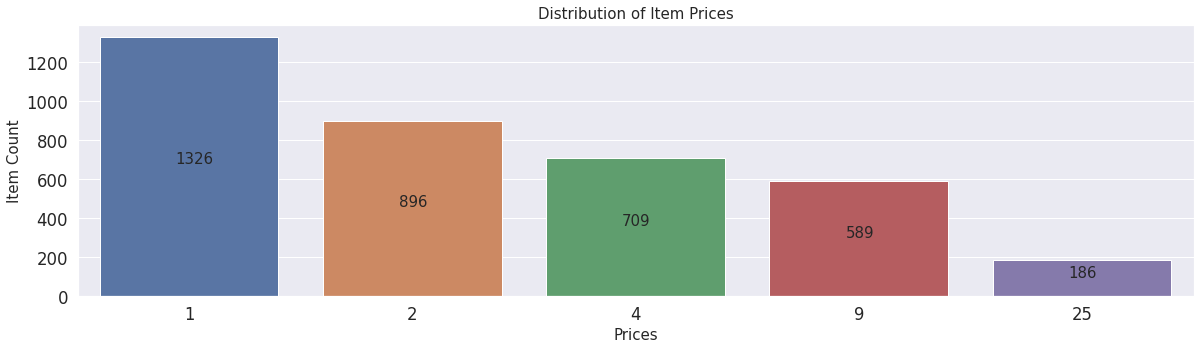

In [7]:
plt.figure(figsize=(20,5))
ax = sns.barplot(x="price", y="item", data=price_df.groupby(['price']).count().reset_index())
ax.set_title('Distribution of Item Prices', fontsize=15)
for i, v in enumerate(price_df.groupby(['price']).count().reset_index()['item']):
  ax.text(i-0.06, v/1.95, str(v), fontsize=15)
ax.set_xlabel("Prices",fontsize=15)
ax.set_ylabel("Item Count",fontsize=15)
plt.show()


***Answer:***

After exploring 3706 items, we can see here that the most of the items have the price of 1₪. Following that there are less items with the price of 2₪, then 4₪, 9₪ and finaly only 186 items with the price of 25₪

b. To evaluate the performance of the price sensitive model we will add another metric
Revenue@K which will measure the overall revenue from the top 5 recommended hits.
Implement the metric. (5 points)


The function will be calculated as follows:
For each user: sum the prices of the top K recommended items which were rated as the revenue
from the user.
Calculate the mean revenue from all users.

In [8]:
# This function returns the price of an item in the ranked list
def get_item_revenue(rank_list, rec_item):
  for item in rank_list:
    if item == rec_item:
      revenue = price_list['price'][rec_item]
      return revenue
  return 0

c. Suggest a metric of your own which will incorporate both the ranking of the recommended
items as well as its price. Explain why this metric is suitable and demonstrate it as part of the
evaluation in point e below. (10 points)

In [9]:
# This function calculates the price of an item with the weight of the reciprocal rank
def get_item_weighted_revenue(rank_list, rec_item):
  for item in rank_list:
    if item == rec_item:
      reciprocal_rank = get_mrr(rank_list, rec_item)
      revenue = price_list['price'][rec_item]
      return reciprocal_rank * revenue
  return 0

***Answer***: 

The suggested metric will incorporate the rank of each of the recommended items. Very similar to the MRR metric we saw in class. Now the weight of each item will be multiplied by the item's reciprocal rank, otherwise, if the item was predicted wrongly to be in the top 5, then its reciprocal rank is 0. 
This metric is significant as we are incorporating the placement of the recommended items as well as their price. So if an expensive item was recommended to be top 1, it will have a very high weight, higher than a cheap item that will be recommended to be top 1. Hence this metric penalizes items that got lower reciprocal rank which is what we want to achieve. 

For reference, this is a diagram that represents how mean reciprocal rank works: 
<center> <img src=https://amitness.com/images/ltr-mean-reciprocal-rank.png width =500> </center>


d. Select one of the models presented in the Neural Collaborative Filtering paper and incorporate
the movie price to the loss function as part of training. (10 points)

In [10]:
%%time 

def get_train_instances(train, num_negatives):
    user_input, item_input, labels, price_weights = [],[],[], []
    num_users = train.shape[0]
    for (u, i) in train.keys():
        # positive instance
        user_input.append(u)
        item_input.append(i)
        labels.append(1) # This is an interacted sample so it gets score 1
        price_weights.append(price_list['price'][i])
        # negative instances
        for t in range(num_negatives):
            j = np.random.randint(num_items)
            while (u, j) in train:
                j = np.random.randint(num_items)
            user_input.append(u)
            item_input.append(j)
            labels.append(0) # This is a non interacted sample so its gets the score 0
            price_weights.append(price_list['price'][i])
    return user_input, item_input, labels, price_weights


user_input, item_input, labels, price_weights = get_train_instances(trainMatrix, num_negatives)
price_weights = np.array(price_weights)
user_train = np.array(user_input)
item_train = np.array(item_input)
labels_train = np.array(labels)
print(f'#Users = {len(user_input)}, #UsersTrain = {len(user_train)}, #Items = {len(item_input)}, #ItemsTrain = {len(item_train)}, #SampleWeights = {len(price_weights)}')

#Users = 4970845, #UsersTrain = 4970845, #Items = 4970845, #ItemsTrain = 4970845, #SampleWeights = 4970845
CPU times: user 17.6 s, sys: 212 ms, total: 17.8 s
Wall time: 17.8 s


In [11]:
# Generalized Matrix Factorization
def get_GMF_model(num_users, num_items, latent_dim, regs=[[0,0]]):
    # Input variables
    user_input = Input(shape=(1,), dtype='int32', name = 'user_input')
    item_input = Input(shape=(1,), dtype='int32', name = 'item_input')
    MF_Embedding_User = Embedding(input_dim = num_users, output_dim = latent_dim, name = 'user_embedding',
                                   embeddings_regularizer = l2(regs[0][0]), input_length=1,embeddings_initializer=RandomNormal(mean=0.0, stddev=0.01)) #init = init_normal,
    MF_Embedding_Item = Embedding(input_dim = num_items, output_dim = latent_dim, name = 'item_embedding',
                                   embeddings_regularizer = l2(regs[0][1]), input_length=1,embeddings_initializer=RandomNormal(mean=0.0, stddev=0.01))  #init = init_normal, 
    # Crucial to flatten an embedding vector!
    user_latent = Flatten()(MF_Embedding_User(user_input))
    item_latent = Flatten()(MF_Embedding_Item(item_input))
    # Element-wise product of user and item embeddings 
    predict_vector = Multiply()([user_latent, item_latent]) 
    # Final prediction layer
    prediction = Dense(1, activation='sigmoid', kernel_initializer='lecun_uniform', name = 'prediction')(predict_vector)
    model = Model(inputs=[user_input, item_input], outputs=prediction)
    return model

In [12]:
# Global variables
_model = None
_testRatings = None
_testNegatives = None
_K = None

# Evaluation Class
def evaluate_model(model, testRatings, testNegatives, K, num_thread):
    global _model
    global _testRatings
    global _testNegatives
    global _K
    _model = model
    _testRatings = testRatings
    _testNegatives = testNegatives
    _K = K
    # initiative evaluation hist
    mrrs5, ndcgs5, revenues5, wrs5 = [],[],[],[]
    # Single thread
    for idx in range(len(_testRatings)):
        (mrr5, ndcg5, revenue5, wr5) = eval_one_rating(idx)
        mrrs5.append(mrr5)
        ndcgs5.append(ndcg5)
        revenues5.append(revenue5)
        wrs5.append(wr5)
    mrr5 = np.array(mrrs5).mean() #mean of all mrrs
    ndcg5 = np.array(ndcgs5).mean() #mean of all ndcgs
    revenue5 = np.array(revenues5).mean() #mean of all revenue@k
    wr5 = np.array(wrs5).mean() #mean of all weighted rank@5
    return (mrr5, ndcg5, revenue5, wr5)

def eval_one_rating(idx):
  rating = _testRatings[idx]
  items = _testNegatives[idx]
  u = rating[0]
  gtItem = rating[1]
  items.append(gtItem)

  # Get prediction scores
  map_item_score = {}
  users = np.full(len(items), u, dtype = 'int32')
  predictions = _model.predict([users, np.array(items)], 
                                batch_size=100, verbose=0)
  for i in range(len(items)):
      item = items[i]
      map_item_score[item] = predictions[i]
  items.pop()
  
  # Evaluate top rank list
  ranklist = heapq.nlargest(_K, map_item_score, key=map_item_score.get)
  revenue5 = get_item_revenue(ranklist, gtItem)
  wr5 = get_item_weighted_revenue(ranklist, gtItem)
  mrr5 = get_mrr(ranklist, gtItem)
  ndcg5 = get_ndcg(ranklist, gtItem)
  return (mrr5, ndcg5, revenue5, wr5)


def get_mrr(ranklist, gtItem):
  for i in range(len(ranklist)):
    item = ranklist[i]
    if item == gtItem:
          return 1/(i+1)
  return 0


def get_ndcg(ranklist, gtItem):
  for i in range(len(ranklist)):
      item = ranklist[i]
      if item == gtItem:
          return math.log(2) / math.log(i+2)
  return 0

The following model uses the item prices as sample weights

In [13]:
%%time
callbacks = [EarlyStopping('val_loss', patience=3), ModelCheckpoint('MODEL_WEIGHTS_FILE_GMF', save_best_only=True)]
model1 = get_GMF_model(num_users, num_items, 
                      num_factors, regs = [[0,0]])
model1.compile(optimizer=Adam(lr=learning_rate), loss='binary_crossentropy')
print(model1.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 8)         48320       user_input[0][0]                 
__________________________________________________________________________________________________
item_embedding (Embedding)      (None, 1, 8)         29648       item_input[0][0]                 
______________________________________________________________________________________________

In [14]:
%%time
(mrr5_sw, ndcg5_sw, revenue5_sw, wr5_sw) = evaluate_model(model1, testRatings, testNegatives, topK, evaluation_threads)
hist_mrr5_sw, hist_ndcgs5_sw, hist_revenue5_sw, hist_weightedrevenue5_sw, hist_losses_sw = [], [], [], [], []

for epoch in range(epochs):
    # Generate training instances
    hist_sw = model1.fit([user_train, item_train], #input
                     labels_train, # labels 
                     batch_size=batch_size, epochs=1, verbose=1, shuffle=True, sample_weight = price_weights)

    # Evaluation
    if epoch %verbose == 0:
        (mrr5_sw, ndcg5_sw, revenue5_sw, wr5_sw) = evaluate_model(model1, testRatings, testNegatives, topK, evaluation_threads)
        # Saving Data
        hist_mrr5_sw.append(mrr5_sw)
        hist_ndcgs5_sw.append(ndcg5_sw)
        hist_revenue5_sw.append(revenue5_sw)
        hist_weightedrevenue5_sw.append(wr5_sw)
        loss = hist_sw.history['loss'][0]
        hist_losses_sw.append(loss)
        print(f'epoch {epoch}: MRR5: {mrr5_sw:.4f}, NDCG5: {ndcg5_sw:.4f}, Revenue5: {revenue5_sw:.4f}, WeightedRevenue5: {wr5_sw: .4f} loss: {loss}')

9709/9709 [==============================] - 31s 3ms/step - loss: 1.7855
epoch 0: MRR5: 0.1230, NDCG5: 0.1483, Revenue5: 2.2614, WeightedRevenue5:  1.4889 loss: 1.4573532342910767
9709/9709 [==============================] - 30s 3ms/step - loss: 1.2325
epoch 1: MRR5: 0.1426, NDCG5: 0.1719, Revenue5: 2.4588, WeightedRevenue5:  1.6115 loss: 1.2325031757354736
9709/9709 [==============================] - 30s 3ms/step - loss: 1.1359
epoch 2: MRR5: 0.1665, NDCG5: 0.2004, Revenue5: 2.6457, WeightedRevenue5:  1.7492 loss: 1.135866641998291
9709/9709 [==============================] - 29s 3ms/step - loss: 1.0764
epoch 3: MRR5: 0.1773, NDCG5: 0.2147, Revenue5: 2.7081, WeightedRevenue5:  1.7618 loss: 1.0763603448867798
9709/9709 [==============================] - 30s 3ms/step - loss: 1.0483
epoch 4: MRR5: 0.1839, NDCG5: 0.2224, Revenue5: 2.7578, WeightedRevenue5:  1.7921 loss: 1.0483442544937134
9709/9709 [==============================] - 29s 3ms/step - loss: 1.0238
epoch 5: MRR5: 0.1909, NDCG5

e. Compare the results of the original model and the one with the customized loss across the four
metrics: MRR@5, NDCG@5,Revenue@5 and your custom metric. Compare between different
heuristics of item price to weights mapping. Present the comparison results, discuss the results
and the trade-offs and optimize. Verify and present that the learning is ‘healthy’ (no overfitting,
no under-fitting and that the results make sense). (20 points)

***Answer:***

For this question we will compare a vanilla GMF model and two heuristic approaches: Samples weight as the item prices AND Sample weights as the normalized item prices.

The following model is a vanilla GMF model with no sample weights

In [15]:
%%time
callbacks = [EarlyStopping('val_loss', patience=3), ModelCheckpoint('MODEL_WEIGHTS_FILE_GMF', save_best_only=True)]
model2 = get_GMF_model(num_users, num_items, 
                      num_factors, regs = [[0,0]])
model2.compile(optimizer=Adam(lr=learning_rate), loss='binary_crossentropy')
print(model2.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 8)         48320       user_input[0][0]                 
__________________________________________________________________________________________________
item_embedding (Embedding)      (None, 1, 8)         29648       item_input[0][0]                 
____________________________________________________________________________________________

In [16]:
%%time
(mrr5, ndcg5, revenue5, wr5) = evaluate_model(model2, testRatings, testNegatives, topK, evaluation_threads)
hist_mrr5, hist_ndcgs5, hist_revenue5, hist_weightedrevenue5, hist_losses = [], [], [], [], []

# Original Model
for epoch in range(epochs):
    # Generate training instances
    hist = model2.fit([user_train, item_train], #input
                     labels_train, # labels 
                     batch_size=batch_size, epochs=1, verbose=1, shuffle=True) #,sample_weight = prices_df['prices'] )

    # Evaluation
    if epoch %verbose == 0:
        (mrr5, ndcg5, revenue5, wr5) = evaluate_model(model2, testRatings, testNegatives, topK, evaluation_threads)
        # Saving Data
        hist_mrr5.append(mrr5)
        hist_ndcgs5.append(ndcg5)
        hist_revenue5.append(revenue5)
        hist_weightedrevenue5.append(wr5)
        loss = hist.history['loss'][0]
        hist_losses.append(loss)  
        print(f'epoch {epoch}: MRR5: {mrr5:.4f}, NDCG5: {ndcg5:.4f}, Revenue5: {revenue5:.4f}, WeightedRevenue5: {wr5: .4f} loss: {loss} ')


9709/9709 [==============================] - 29s 3ms/step - loss: 0.4338
epoch 0: MRR5: 0.1787, NDCG5: 0.2138, Revenue5: 1.5690, WeightedRevenue5:  0.8985 loss: 0.3761462867259979 
9709/9709 [==============================] - 29s 3ms/step - loss: 0.3234
epoch 1: MRR5: 0.2104, NDCG5: 0.2502, Revenue5: 1.7932, WeightedRevenue5:  1.0379 loss: 0.3233833312988281 
9709/9709 [==============================] - 28s 3ms/step - loss: 0.2966
epoch 2: MRR5: 0.2267, NDCG5: 0.2706, Revenue5: 1.9371, WeightedRevenue5:  1.0631 loss: 0.2965521514415741 
9709/9709 [==============================] - 29s 3ms/step - loss: 0.2872
epoch 3: MRR5: 0.2325, NDCG5: 0.2769, Revenue5: 1.9949, WeightedRevenue5:  1.0985 loss: 0.28715571761131287 
9709/9709 [==============================] - 29s 3ms/step - loss: 0.2828
epoch 4: MRR5: 0.2343, NDCG5: 0.2799, Revenue5: 2.0371, WeightedRevenue5:  1.1044 loss: 0.2827620804309845 
9709/9709 [==============================] - 29s 3ms/step - loss: 0.2756
epoch 5: MRR5: 0.2431

Now we calculate normalizing price_weights according to:
$$
z_i=\frac{x_i-\min(x)}{\max(x)-\min(x)}$$

In [17]:
def normalize(df):
  min = price_weights.min()
  max = price_weights.max()
  diff = max - min
  norm_df = (df - min)/diff
  return norm_df

# Validating that normlization worked
norm_price_weights = normalize(price_weights)
unique, counts = np.unique(norm_price_weights, return_counts=True)
print(np.asarray((unique, counts)).T)

[[0.00000000e+00 1.81479000e+06]
 [4.16666667e-02 1.18752500e+06]
 [1.25000000e-01 9.06170000e+05]
 [3.33333333e-01 7.98220000e+05]
 [1.00000000e+00 2.64140000e+05]]


The following model is a GMF model with sample weights as the normalized item prices

In [18]:
%%time
callbacks = [EarlyStopping('val_loss', patience=3), ModelCheckpoint('MODEL_WEIGHTS_FILE_GMF', save_best_only=True)]
model3 = get_GMF_model(num_users, num_items, 
                      num_factors, regs = [[0,0]])
model3.compile(optimizer=Adam(lr=learning_rate), loss='binary_crossentropy')
print(model3.summary())

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 8)         48320       user_input[0][0]                 
__________________________________________________________________________________________________
item_embedding (Embedding)      (None, 1, 8)         29648       item_input[0][0]                 
____________________________________________________________________________________________

In [19]:
%%time
#sw_norm = normalized sample weight 
(mrr5_sw_norm, ndcg5_sw_norm, revenue5_sw_norm, wr5_sw_norm) = evaluate_model(model3, testRatings, testNegatives, topK, evaluation_threads)
hist_mrr5_sw_norm, hist_ndcgs5_sw_norm, hist_revenue5_sw_norm, hist_weightedrevenue5_sw_norm, hist_losses_sw_norm = [], [], [], [], []

for epoch in range(epochs):
    # Generate training instances
    hist_sw_norm = model3.fit([user_train, item_train], #input
                     labels_train, # labels 
                     batch_size=batch_size, epochs=1, verbose=1, shuffle=True, sample_weight = norm_price_weights)
    # Evaluation
    if epoch %verbose == 0:
        (mrr5_sw_norm, ndcg5_sw_norm, revenue5_sw_norm, wr5_sw_norm) = evaluate_model(model3, testRatings, testNegatives, topK, evaluation_threads)
        # Saving Data
        hist_mrr5_sw_norm.append(mrr5_sw_norm)
        hist_ndcgs5_sw_norm.append(ndcg5_sw_norm)
        hist_revenue5_sw_norm.append(revenue5_sw_norm)
        hist_weightedrevenue5_sw_norm.append(wr5_sw_norm)
        loss = hist_sw_norm.history['loss'][0]
        hist_losses_sw_norm.append(loss)
        print(f'epoch {epoch}: MRR5: {mrr5_sw_norm:.4f}, NDCG5: {ndcg5_sw_norm:.4f}, Revenue5: {revenue5_sw_norm:.4f}, WeightedRevenue5: {wr5_sw_norm: .4f} loss: {loss} ')


9709/9709 [==============================] - 30s 3ms/step - loss: 0.0559
epoch 0: MRR5: 0.1077, NDCG5: 0.1290, Revenue5: 2.3015, WeightedRevenue5:  1.4700 loss: 0.04225932061672211 
9709/9709 [==============================] - 29s 3ms/step - loss: 0.0332
epoch 1: MRR5: 0.1203, NDCG5: 0.1439, Revenue5: 2.3917, WeightedRevenue5:  1.5677 loss: 0.03319700434803963 
9709/9709 [==============================] - 30s 3ms/step - loss: 0.0308
epoch 2: MRR5: 0.1343, NDCG5: 0.1607, Revenue5: 2.5836, WeightedRevenue5:  1.6796 loss: 0.030840430408716202 
9709/9709 [==============================] - 30s 3ms/step - loss: 0.0290
epoch 3: MRR5: 0.1450, NDCG5: 0.1735, Revenue5: 2.6813, WeightedRevenue5:  1.7312 loss: 0.028969863429665565 
9709/9709 [==============================] - 30s 3ms/step - loss: 0.0279
epoch 4: MRR5: 0.1477, NDCG5: 0.1787, Revenue5: 2.7224, WeightedRevenue5:  1.7253 loss: 0.027893483638763428 
9709/9709 [==============================] - 30s 3ms/step - loss: 0.0272
epoch 5: MRR5:

Model metric comparisons

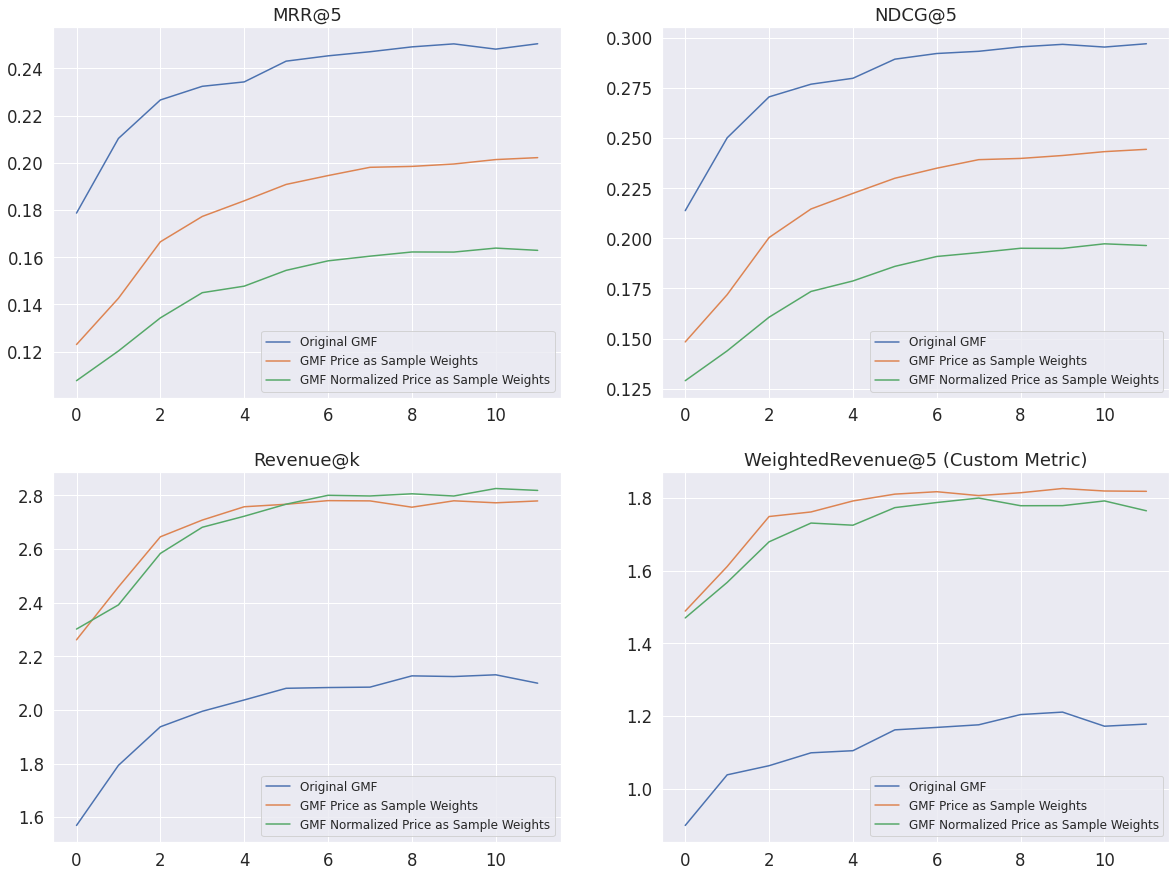

In [20]:
fig, ax = plt.subplots(2,2,figsize=(20, 15))

ax[0,0].title.set_text('MRR@5')
ax[0,0].plot(hist_mrr5, label = 'Original GMF')
ax[0,0].plot(hist_mrr5_sw, label = 'GMF Price as Sample Weights')
ax[0,0].plot(hist_mrr5_sw_norm, label = 'GMF Normalized Price as Sample Weights')
ax[0,0].legend(prop={'size': 12})

ax[0,1].title.set_text('NDCG@5')
ax[0,1].plot(hist_ndcgs5, label = 'Original GMF')
ax[0,1].plot(hist_ndcgs5_sw, label = 'GMF Price as Sample Weights')
ax[0,1].plot(hist_ndcgs5_sw_norm, label = 'GMF Normalized Price as Sample Weights')
ax[0,1].legend(prop={'size': 12})

ax[1,0].title.set_text('Revenue@k')
ax[1,0].plot(hist_revenue5, label = 'Original GMF')
ax[1,0].plot(hist_revenue5_sw, label = 'GMF Price as Sample Weights')
ax[1,0].plot(hist_revenue5_sw_norm, label = 'GMF Normalized Price as Sample Weights')
ax[1,0].legend(prop={'size': 12})

ax[1,1].title.set_text('WeightedRevenue@5 (Custom Metric)')
ax[1,1].plot(hist_weightedrevenue5, label = 'Original GMF')
ax[1,1].plot(hist_weightedrevenue5_sw, label = 'GMF Price as Sample Weights')
ax[1,1].plot(hist_weightedrevenue5_sw_norm, label = 'GMF Normalized Price as Sample Weights')
ax[1,1].legend(prop={'size': 12})

plt.show()

Plotting model losses

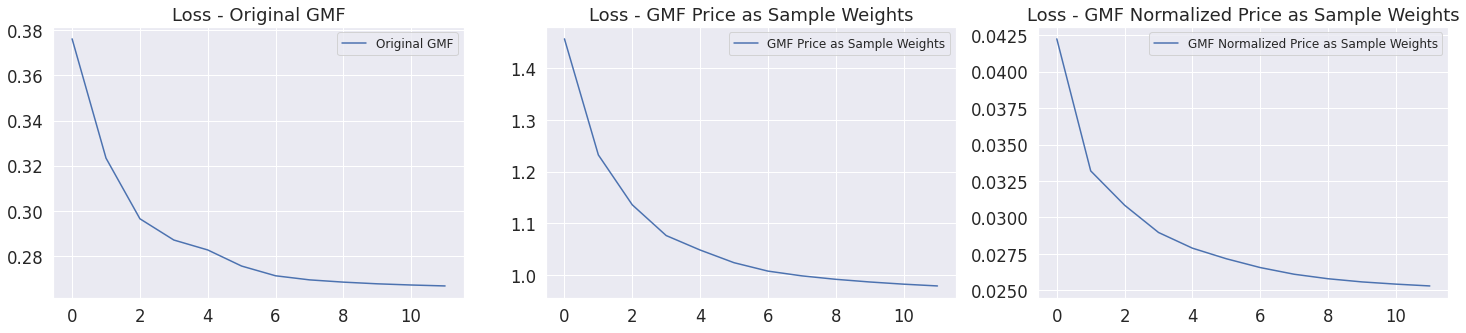

In [22]:
fig, ax = plt.subplots(1,3,figsize=(25, 5))

ax[0].title.set_text('Loss - Original GMF')
ax[0].plot(hist_losses, label = 'Original GMF')
ax[0].legend(prop={'size': 12})

ax[1].title.set_text('Loss - GMF Price as Sample Weights')
ax[1].plot(hist_losses_sw, label = 'GMF Price as Sample Weights')
ax[1].legend(prop={'size': 12})

ax[2].title.set_text('Loss - GMF Normalized Price as Sample Weights')
ax[2].plot(hist_losses_sw_norm, label = 'GMF Normalized Price as Sample Weights')
ax[2].legend(prop={'size': 12})

plt.show()

***Answer Cont...*** 

In the results above we can conclude the following:
For the MRR@5 metric, the best performing model is the original GMF (with no sample weights), in contrast to the worst-performing model which is the GMF with normalized price as the sample weights. This is expected as discussed in 1b as the normalized sample weights disregard items with a price of 1. A similar trend also appears in the NDCG@5 metric where the Original GMF is performing best and the GMF with normalized price as sample weights are performing worse for the same reason. We are essentially disregarding most of the items as most items have the price of 1.

For the newly introduced metric measurements, Revenue@5, we can see that the original GMF is performing worse than the models with sample weights. This is because, for the original GMF, all the samples have the same weight (no weights for different samples). Whereas, for the models with sample weights, we can see that there is an increased impact on the Revenue@5 metric. This is explained as the different weights on the samples simulate higher revenue extremities, expensive items will generate more revenue. 
Notice that there is no significant difference between the two heuristics of the sample weights. This is explained as in the GMF with normalized price sample weights we essentially disregard the items with prices that make a very little impact (item prices 1 weight 0). Similarly, for the WeightedRevenue@5 , the custom metric created, we see the same trend. The Original GMF performed worse whereas both heuristics for sample weights performed better for the same explanation above. 

Lastly, we look at the loss of all three models. 
It is very significant here to see that the overall loss for GMF with sample weights as prices is the biggest. This is due to the fact that misclassifying an expensive item will have a bigger impact on the calculated loss. We can see that this contrasts with the loss of the GMF model with the normalized price for sample weights. The loss here is very small in comparison to the two other models. The logic that explains this is that as most items (we saw in 2a) have the price of 1 and due to the weight being 0, then misclassifying them does not impact the loss, hence the loss is very low. 
 

## Question 3: Hybrid recommender systems (15 points)
Cold start or users\items with a small number of interactions is a very common scenario in real world. In
this question you will plan how you can leverage content based features to handle the cold start
scenario. 

a. Take a look at the original MovieLens 1M dataset. Which user and movie features could you use
to enhance your recommender system and provide effective recommendations to users or
items with a small number of ratings. (5 points)

***Answer:***

Looking at the [original MovieLens 1M dataset](http://files.grouplens.org/datasets/movielens/ml-1m-README.txt), all the possible user features are;
- Gender (2 unique values)
- Age (7 unique values)
- Occupation (20 unique values)
- Zip Code 

All the possible movie features are: 
- Title (unique per movie) - *Not expcting this feature to yield enriched recommendation because it may be very similar to movie ID*
- Genres (18 unique values)

Ideally, we would want to use these additional features in our model when we don't know much about the user. Meaning, when a user didn't rate many movies. Then we can either look for users who have similar characteristics to him to enrich our recommendation. or look at similar movies to the small number of movies rated by the user. The similarity between users/ movies can be calculated by using the features of either users/movies with any of the similarity functions we saw in the course such as cosine similarity. 

In particular, notice that the more features we use to find similar users/movies, the more accurate our similarity scores will be. We can, for example, use **occupation** for user features as it has more unique values and may lead to higher similarity accuracy. While for movies, we can use the **genre** feature to find similarities between movies, as we did in the course in the past. 

Notice that it is very significant and enriching to incorporate user/movie features considering that these features will help us improve the accuracy of similarity measurements and we will be able to depend on the ratings of similar users/movies.

b. Describe a neural network based model to incorporate user or movie related features to the recommender system. Explain your suggestion. (there is no need to implement, provide pseudo
code\visual). (5 points) 

***Answer:***

Consider a GMF neural network-based model that incorporates user/movie-related features to the recommender system in the following way. The neural network will use factorization machines where the data structure will include all the additional features we wish to add; age, gender, occupation, zipcode and movie genre. Notice that for features that are split into multiple categories (Occupation and Gender) and that arent continuous, we will do one-hot encodings.

In the GMF model, we will have a total of 7 embedding layers. The embedding layers will be made up of user IDs, item ID, user age, user gender, user occupation, user zip code and movie genre. 

```
MF_Embedding_User_ID (type: int)
MF_Embedding_Item_ID (type: int)
MF_Embedding_User_Age (type: int)
MF_Embedding_User_Gender (type: boolean (1 for male, 0 for female)) 
MF_Embedding_User_Occupation (type: int (20 different values))
MF_Embedding_User_ZipCode (type: string)
MF_Embedding_Item_Genre (type: int (18 different values))
```

Then we will obtain the latent vectors from each embedding layer in order to flatten the embedding vector
```
user_id_latent 
item_id_latent
user_age_lantent
user_gender_lantent
user_ocupation_lantent
user_zipcode_lantent
item_genre_lantent
```
We will create a prediction vector by computing Element wise product for all the latent vectors 
```
predict_vector = Multiply()([<latent_vectors>]) 
```
Then the final prediction layer will use the sigmoid activation layer on the predict vector
```
prediction = Dense(1, activation='sigmoid', kernel_initializer='lecun_uniform', name = 'prediction')(predict_vector)
```

This gives us a dot product of all the possible interactions between the different features from the embedding layers.
*Notice that we can incorprate the feature and global biases if we wish*

c. How will you incorporate movie genres into the recommender system? How will you handle
movies which belong to multiple genres? Explain the challenge and the proposed solution (there
is no need to implement, provide pseudo-code). (5 points) 

***Answer:***
As explained above, handling movie genres into the GMF model will be by first converting it into one-hot vectors, then compute the dot product between the all the relevant genres latent vecotor. 

For movies that have mulitple genres, the one hot vector will be altered to support mulitple genres and will be similar to a latent vector form. So for each movie that has multiple genres, the vector will have a positive boolean values (1) for every genre. 

For example:
```
item_genre_latent = [0,1,1,0,0]
```
shows how an item can hold two genres 




# Submission Instructions

Submit your solution in the form of an Jupyter notebook file (with extension ipynb). Images of graphs
or tables should be submitted as part of the notebook itself. The code used to answer the questions
should be included, runnable and documented in the notebook. Python 3.6 or higher should be used.